## VGG16 w/ OASIS-1 dataset - Multiclass

##### Summary: this notebook is the VGG16 model with the OASIS 1 dataset using multiclass metrics.

#### Notebook setup

In [ ]:
!pip install torchsummary
!pip install pytorch-lightning
!pip install lightning
!pip install optuna

# importing all necessary packages
import pandas as pd
import numpy as np
import cv2
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics
from torchmetrics.classification import BinaryF1Score
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from lightning.pytorch import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import os
from os import listdir
from os.path import join
import random

from PIL import Image

torch.set_float32_matmul_precision("high")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 48.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [ ]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
import zipfile
import os

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')


# Path to the zip file in Google Drive
zip_path = '/content/drive/My Drive/CS231N/Final_Project/archive.zip'

# Temporary directory where you want to unzip the files
unzip_dir = '/content/OASIS_1_dataset'

# Create a directory if it doesn't exist
os.makedirs(unzip_dir, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f'Unzipped the files in {unzip_dir}')
mri_image_path = '/content/OASIS_1_dataset/Curated OASIS/'


Mounted at /content/drive
Unzipped the files in /content/OASIS_1_dataset


#### Visualizing a few MRI scans

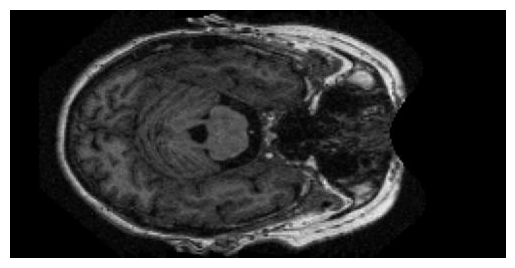

In [ ]:
# Load an image from Healthy
sample_image_path = mri_image_path + 'Train/label_Healthy/OAS1_0001_MR1_mpr-1_100.jpg'
img = Image.open(sample_image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

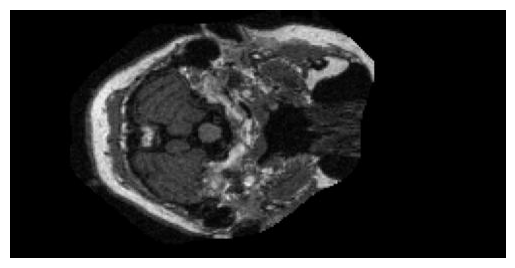

In [ ]:
# Load an image from VeryMild
sample_image_path = mri_image_path + 'Train/label_VeryMild/OAS1_0003_MR1_mpr-1_100.jpg'
img = Image.open(sample_image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

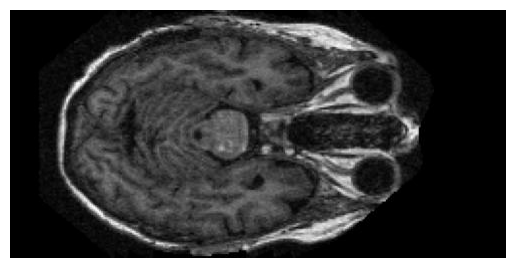

In [ ]:
# Load an image from MildModerate
sample_image_path = mri_image_path + 'Train/label_MildModerate/OAS1_0028_MR1_mpr-1_112.jpg'
img = Image.open(sample_image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

#### Data Preparation

In [ ]:
# Getting the total number of images under each label:
def count_categories(subsets):
  # Categories you are interested in
  categories = ['label_Healthy', 'label_MildModerate', 'label_VeryMild']

  # Function to count JPG files
  def count_jpg_files(directory):
      count = 0
      for root, dirs, files in os.walk(directory):
          count += sum(1 for file in files if file.lower().endswith('.jpg'))
      return count

  # Counting JPG files in each category across all sets
  total_counts = {category: 0 for category in categories}
  for category in categories:
      # Include counts from Train, Validation, and Test
      for subset in subsets:
          path = os.path.join(mri_image_path, subset, category)
          total_counts[category] += count_jpg_files(path)

  # Display the total counts
  for category, count in total_counts.items():
      print(f"Total JPGs in {category}: {count}")

count_categories(['Train', 'Test', 'Validation']) # This is counting across all the subsets

Total JPGs in label_Healthy: 67222
Total JPGs in label_MildModerate: 5490
Total JPGs in label_VeryMild: 13725


In [ ]:
# Drilling in deeper - per train, val, test:

print('For Train:')
count_categories(['Train'])
print('For Validation:')
count_categories(['Validation'])
print('For Test:')
count_categories(['Test'])

For Train:
Total JPGs in label_Healthy: 47336
Total JPGs in label_MildModerate: 3843
Total JPGs in label_VeryMild: 9455
For Validation:
Total JPGs in label_Healthy: 13298
Total JPGs in label_MildModerate: 1159
Total JPGs in label_VeryMild: 3050
For Test:
Total JPGs in label_Healthy: 6588
Total JPGs in label_MildModerate: 488
Total JPGs in label_VeryMild: 1220


In [ ]:
def augment_datasets(label, min_count=12000):
  # Define the directory containing your images
  data_dir = os.path.join(mri_image_path, label)

  # Define categories and target counts
  categories = ['label_Healthy', 'label_VeryMild', 'label_MildModerate']

  # Augmentation pipeline
  augment_transforms = transforms.Compose([
      transforms.RandomRotation(20),
      transforms.RandomHorizontalFlip(),
      transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
  ])

  def augment_images(category, num_needed):
      category_path = os.path.join(data_dir, category)
      images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith('.jpg')]

      i = 0
      while i < num_needed:
          for img_path in images:
              if i >= num_needed:
                  break
              img = Image.open(img_path).convert('RGB')
              augmented_img = augment_transforms(img)
              augmented_img.save(os.path.join(category_path, f'aug_{i}_{os.path.basename(img_path)}'))
              i += 1
      print(f'Saved {i} augmented images in {category_path}', end='\r')

  # Determine how many images to augment for each category
  for category in categories:
      category_path = os.path.join(data_dir, category)
      current_count = len([name for name in os.listdir(category_path) if name.endswith('.jpg')])
      if current_count < min_count:
          print(f'Augmenting for {category}')
          augment_needed = min_count - current_count
          augment_images(category, augment_needed)


augment_datasets('Train')

Augmenting for label_VeryMild
Augmenting for label_MildModerate


In [ ]:
folders = ['label_Healthy', 'label_VeryMild', 'label_MildModerate']

def get_data(path, folders, max_samples_per_category=None):
    pathname_list, labels = [], []
    # Gather file paths and labels
    for folder in folders:
        folder_path = join(path, folder)
        print(folder_path)
        files = [f for f in listdir(folder_path) if not f.startswith('.')]
        # Optionally limit the number of files to include from each folder
        max_sample_for_category = max_samples_per_category[folders.index(folder)] if max_samples_per_category else None
        print(f"max_sample_for_category: {max_sample_for_category}")
        if max_samples_per_category:
            random.shuffle(files)  # Shuffle before slicing to randomize the files selected
            files = files[:max_sample_for_category]
        # Extend lists with the new data
        pathname_list.extend(join(folder_path, f) for f in files)
        labels.extend(folder for _ in files)

    # Shuffle the lists
    random.seed(RANDOM_SEED)  # Set the random seed for reproducibility
    combined = list(zip(pathname_list, labels))
    random.shuffle(combined)

    # Unzip the combined list back into two lists
    pathname_list, labels = zip(*combined)

    return pathname_list, labels

# Healthy, VeryMild, MildModerate
max_samples_per_category = [30000, None, None]  # Set the cap for samples per category for training and validation

# Applying the cap to training and validation datasets
X_train_path, y_train = get_data(join(mri_image_path, 'Train'), folders, max_samples_per_category)
X_val_path, y_val = get_data(join(mri_image_path, 'Validation'), folders)
X_test_path, y_test = get_data(join(mri_image_path, 'Test'), folders)  # No cap for test data


/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy
max_sample_for_category: 30000
/content/OASIS_1_dataset/Curated OASIS/Train/label_VeryMild
max_sample_for_category: None
/content/OASIS_1_dataset/Curated OASIS/Train/label_MildModerate
max_sample_for_category: None
/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy
max_sample_for_category: None
/content/OASIS_1_dataset/Curated OASIS/Validation/label_VeryMild
max_sample_for_category: None
/content/OASIS_1_dataset/Curated OASIS/Validation/label_MildModerate
max_sample_for_category: None
/content/OASIS_1_dataset/Curated OASIS/Test/label_Healthy
max_sample_for_category: None
/content/OASIS_1_dataset/Curated OASIS/Test/label_VeryMild
max_sample_for_category: None
/content/OASIS_1_dataset/Curated OASIS/Test/label_MildModerate
max_sample_for_category: None


In [ ]:
# Check Train set
print("Train Set")
print(len(X_train_path), len(y_train))
print(X_train_path[-5:])
print(y_train[-5:])

# Check Validation set
print("Validation Set")
print(len(X_val_path), len(y_val))
print(X_val_path[-5:])
print(y_val[-5:])

# Check Test set
print("Test Set")
print(len(X_test_path), len(y_test))
print(X_test_path[-5:])
print(y_test[-5:])

Train Set
54000 54000
('/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy/OAS1_0340_MR1_mpr-4_103.jpg', '/content/OASIS_1_dataset/Curated OASIS/Train/label_MildModerate/aug_4816_OAS1_0269_MR1_mpr-4_120.jpg', '/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy/OAS1_0275_MR1_mpr-1_118.jpg', '/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy/OAS1_0168_MR1_mpr-4_119.jpg', '/content/OASIS_1_dataset/Curated OASIS/Train/label_VeryMild/OAS1_0288_MR1_mpr-1_152.jpg')
('label_Healthy', 'label_MildModerate', 'label_Healthy', 'label_Healthy', 'label_VeryMild')
Validation Set
17507 17507
('/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy/OAS1_0343_MR1_mpr-2_143.jpg', '/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy/OAS1_0259_MR1_mpr-1_112.jpg', '/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy/OAS1_0139_MR1_mpr-3_121.jpg', '/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy/OAS1_0259_MR1_mpr-3_142.jpg', '/content/OA

In [ ]:
# Count the occurrences of each label
def count_labels(labels_list, percentage=False):

    healthy_count = labels_list.count('label_Healthy')
    vmild_count = labels_list.count('label_VeryMild')
    mildmod_count = labels_list.count('label_MildModerate')

    # Calculate the percentages
    total_count = len(labels_list)
    healthy_percentage = (healthy_count / total_count) * 100
    vmild_percentage = (vmild_count / total_count) * 100
    mildmod_percentage = (mildmod_count / total_count) * 100

    # Print the results
    if percentage:
      print(f"'healthy_percentage' percentage: {healthy_percentage:.2f}%")
      print(f"'vmild_percentage' percentage: {vmild_percentage:.2f}%")
      print(f"'mildmod_percentage' percentage: {mildmod_percentage:.2f}%")
    else:
      print(f"Healthy count: {healthy_count}")
      print(f"VeryMild count: {vmild_count}")
      print(f"MildModerate count: {mildmod_count}")

print("Train set:")
count_labels(y_train)

print("Validation set:")
count_labels(y_val)

print("Test set:")
count_labels(y_test)

Train set:
Healthy count: 30000
VeryMild count: 12000
MildModerate count: 12000
Validation set:
Healthy count: 13298
VeryMild count: 3050
MildModerate count: 1159
Test set:
Healthy count: 6588
VeryMild count: 1220
MildModerate count: 488


In [ ]:
# Encode Labels (Y) to numerical values

# Define the mapping
label_mapping = {'label_Healthy': 0, 'label_VeryMild': 1, 'label_MildModerate': 2}

# Use map to apply the mapping
y_train_encoded = list(map(lambda x: label_mapping[x], y_train))
y_val_encoded = list(map(lambda x: label_mapping[x], y_val))
y_test_encoded = list(map(lambda x: label_mapping[x], y_test))

#### Creating OASIS1MRIDataset from JPG image paths

In [ ]:
class OASIS1MRIDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.image_path = X
        self.label = y
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx])
        image = self.transform(image)
        targets = self.label[idx]
        return image.float(), torch.tensor(targets)

    def show_transforms(self, idx):
        image = Image.open(self.image_path[idx])
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        transformed_image = self.transform(image)
        # Convert tensor to image for display
        transformed_image = transformed_image.permute(1, 2, 0)  # Change from CxHxW to HxWxC
        transformed_image = transformed_image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        transformed_image = transformed_image.clamp(0, 1)
        plt.imshow(transformed_image)
        plt.title('Transformed Image')
        plt.show()

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

default_val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating Train, Validation, and Test Datasets

train_dataset = OASIS1MRIDataset(X_train_path, y_train_encoded, train_transforms)
val_dataset = OASIS1MRIDataset(X_val_path, y_val_encoded, default_val_test_transform)
test_dataset = OASIS1MRIDataset(X_test_path, y_test_encoded, default_val_test_transform)

# train_dataset.show_transforms(50)
# val_dataset.show_transforms(50)
# test_dataset.show_transforms(50)

In [ ]:
# Creating Train, Validation, and Test Dataloaders

def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=256, num_workers=10):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=10)
  return train_loader, valid_loader, test_loader

train_loader, valid_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset)

#### Creating VGG16 Model Architecture and running model

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import BinaryAccuracy
import torchmetrics

class BaseNet(pl.LightningModule):
    def __init__(self, model, learning_rate, num_classes):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_classes = num_classes

         # Define loss function with class weights (to address class imbalance)
        self.class_weights = self.compute_class_weights()  # Compute class weights
        self.ce_loss = nn.CrossEntropyLoss(weight=self.class_weights) # Loss function

        # Multiclass metrics to collect
        self.accuracy = BinaryAccuracy()
        self.balanced_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='macro')

        # AUROC Metrics - Multiclass classification, Weighted average due to class imbalance
        self.mlc_auroc = torchmetrics.AUROC(task="multiclass", num_classes=num_classes, average="weighted")
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        # Calculate CE Loss
        loss = self.ce_loss(logits, y)
        self.log('train_loss', loss)

        # Calculating regular accuracy
        binary_preds = (preds == y).int()
        all_ones = torch.ones_like(binary_preds)
        acc = self.accuracy(binary_preds, all_ones)
        self.log('train_acc', acc, prog_bar=True)

        # Calculating balanced accuracy
        train_bac = self.balanced_accuracy(logits, y)
        self.log('train_bac', train_bac)

        # Calculating AUROC
        y_hat = F.softmax(logits, dim=1)  # Apply softmax to normalise logits
        auroc = self.mlc_auroc(y_hat, y)   # calculate auroc
        self.log('train_auroc', auroc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        # Calculate CE Loss
        loss = self.ce_loss(logits, y)
        self.log('val_loss', loss)

        # Calculating regular accuracy
        binary_preds = (preds == y).int()
        all_ones = torch.ones_like(binary_preds)
        acc = self.accuracy(binary_preds, all_ones)
        self.log('val_acc', acc, prog_bar=True)

        # Calculating balanced accuracy
        balanced_accuracy = self.balanced_accuracy(logits, y)
        self.log('val_bac', balanced_accuracy)

        # Calculating AUROC
        y_hat = F.softmax(logits, dim=1)
        auroc = self.mlc_auroc(y_hat, y)
        self.log('val_auroc', auroc, prog_bar=True)


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        probs = F.softmax(logits, dim=1)

        # Calculate CE Loss
        loss = self.ce_loss(logits, y)
        self.log('test_loss', loss)

        # Calculating regular accuracy
        binary_preds = (preds == y).int()
        all_ones = torch.ones_like(binary_preds)
        acc = self.accuracy(binary_preds, all_ones)
        self.log('test_acc', acc, prog_bar=True)

        # Calculated balanced accuracy
        bac = self.balanced_accuracy(preds, y)
        self.log('test_bac', bac, prog_bar=True)

        # Calculate AUROC
        y_hat = F.softmax(logits, dim=1)
        auroc = self.mlc_auroc(y_hat, y)
        self.log('test_auroc', auroc, prog_bar=True)
        return {
            'test_loss': loss,
            'test_acc': acc,
            'test_bac': bac,
            'test_auroc': auroc
        }

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def compute_class_weights(self):
      class_counts = [265, 58, 23]  # Example counts
      total_samples = sum(class_counts)
      class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
      return torch.tensor(class_weights, dtype=torch.float32)

In [18]:
from torchvision.models import vgg16, VGG16_Weights
import torch.nn as nn
import optuna

class ModifiedVGG16(BaseNet):
    def __init__(self, learning_rate, num_classes):
        weights = VGG16_Weights.DEFAULT
        model = vgg16(weights=weights)

        # Freeze all the layers first
        for param in model.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer with a new classifier
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs // 2),
            nn.ReLU(),
            nn.Linear(num_ftrs // 2, num_classes)
        )

        # Unfreeze the new layers in the classifier
        for param in model.classifier[6].parameters():
            param.requires_grad = True

        super().__init__(model, learning_rate, num_classes)

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # Setup model
    model = ModifiedVGG16(learning_rate=learning_rate, num_classes=3)

    # Setup DataLoaders to take in batch size as a hyperparam
    train_loader, valid_loader, _ = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=batch_size)

    logger = TensorBoardLogger("lightning_logs/", name="VGG16MC", version="v0.1", log_graph=True)
    checkpoint_callback = ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        save_top_k=1,
        dirpath='VGG16MC/checkpoint/'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_acc',
        min_delta=0.001,
        patience=3,
        verbose=True,
        mode='max'
    )
    trainer = pl.Trainer(
        min_epochs=8,
        max_epochs=15,
        logger=logger,
        callbacks=[checkpoint_callback, early_stop_callback],
        log_every_n_steps=10
    )

    model.example_input_array = torch.randn(1, 3, 224, 224)

    # Fit the model
    trainer.fit(model, train_loader, valid_loader)

    # Retrive the best score achieved
    best_model_score = checkpoint_callback.best_model_score
    return best_model_score.item() if best_model_score is not None else float('nan')

# Create a study object that will optimize the objective
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# # Instantiate the model
# model = ModifiedVGG16(learning_rate=1e-4, num_classes=3)  # Multiclass classification: num_class = 3


# # Define a checkpoint callback to save the best model based on validation F1 score
# checkpoint_callback = ModelCheckpoint(
#     monitor='val_auroc',
#     mode='max',
#     save_top_k=1,
#     dirpath='VGG16MC/checkpoint/'
# )

# # Perform early stopping by tracking improvement in validation accuracy score
# early_stop_callback = EarlyStopping(
#     monitor='val_auroc',   # monitor validation auroc
#     min_delta=0.001,
#     patience=2,           # stop if no improvement after 2 epochs
#     verbose=True,
#     mode='max'
# )

# # Training
# logger = TensorBoardLogger("lightning_logs/", name="VGG16MC", version="v0.1", log_graph=True)

# trainer = pl.Trainer(
#     min_epochs=8,
#     max_epochs=15,
#     logger=logger,
#     callbacks=[checkpoint_callback, early_stop_callback],
#     log_every_n_steps=10
# )
# model.example_input_array = torch.randn(1, 3, 224, 224)

# #train the model
# trainer.fit(model, train_loader, valid_loader)

[I 2024-06-03 19:52:51,477] A new study created in memory with name: no-name-07b0d201-8780-4c82-a6fd-c26457c88c94
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 227MB/s]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.util

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.601


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.007 >= min_delta = 0.001. New best score: 0.609


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.609. Signaling Trainer to stop.
INFO: Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...
INFO:lightning.pytorch.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.014 >= min_delta = 0.001. New best score: 0.622
[I 2024-06-03 20:47:48,948] Trial 0 finished with value: 0.6223796010017395 and parameters: {'learning_rate': 0.00030354091186345, 'batch_size': 256}. Best is trial 0 with value: 0.6223796010017395.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/VGG16MC/checkpoint exists and is not empty.
INFO:pyto

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.582


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.035 >= min_delta = 0.001. New best score: 0.617


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.016 >= min_delta = 0.001. New best score: 0.633


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.633. Signaling Trainer to stop.
INFO: Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...
INFO:lightning.pytorch.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 4 records. Best score: 0.633. Signaling Trainer to stop.
[I 2024-06-03 21:16:19,311] Trial 1 finished with value: 0.6334608793258667 and parameters: {'learning_rate': 0.0004718435161880825, 'batch_size': 256}. Best is trial 1 with value: 0.6334608793258667.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.598


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.006 >= min_delta = 0.001. New best score: 0.604


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.604. Signaling Trainer to stop.
INFO: Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...
INFO:lightning.pytorch.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.048 >= min_delta = 0.001. New best score: 0.652
[I 2024-06-03 21:49:09,519] Trial 2 finished with value: 0.6515108346939087 and parameters: {'learning_rate': 0.0016070615014045788, 'batch_size': 128}. Best is trial 2 with value: 0.6515108346939087.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.588


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.005 >= min_delta = 0.001. New best score: 0.594


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.023 >= min_delta = 0.001. New best score: 0.617


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.617. Signaling Trainer to stop.
[I 2024-06-03 22:27:27,416] Trial 3 finished with value: 0.6165533661842346 and parameters: {'learning_rate': 0.0007363687528685346, 'batch_size': 128}. Best is trial 2 with value: 0.6515108346939087.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.612


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.020 >= min_delta = 0.001. New best score: 0.633


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.633. Signaling Trainer to stop.
INFO: Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...
INFO:lightning.pytorch.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 4 records. Best score: 0.633. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 5 records. Best score: 0.633. Signaling Trainer to stop.
[I 2024-06-03 22:56:00,877] Trial 4 finished with value: 0.6329468488693237 and parameters: {'learning_rate': 0.004763049910430548, 'batch_size': 256}. Best is trial 2 with value: 0.6515108346939087.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.636


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.636. Signaling Trainer to stop.
INFO: Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...
INFO:lightning.pytorch.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 4 records. Best score: 0.636. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 5 records. Best score: 0.636. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 6 records. Best score: 0.636. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 7 records. Best score: 0.636. Signaling Trainer to stop.
[I 2024-06-03 23:28:53,464] Trial 5 finished with value: 0.6362026333808899 and parameters: {'learning_rate': 0.007227968595680254, 'batch_size': 128}. Best is trial 2 with value: 0.6515108346939087.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.606


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.029 >= min_delta = 0.001. New best score: 0.635


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.008 >= min_delta = 0.001. New best score: 0.643


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.643. Signaling Trainer to stop.
[I 2024-06-03 23:57:38,789] Trial 6 finished with value: 0.642885684967041 and parameters: {'learning_rate': 0.005219206017285938, 'batch_size': 256}. Best is trial 2 with value: 0.6515108346939087.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.611


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.014 >= min_delta = 0.001. New best score: 0.625


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.625. Signaling Trainer to stop.
INFO: Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...
INFO:lightning.pytorch.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.010 >= min_delta = 0.001. New best score: 0.636


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.007 >= min_delta = 0.001. New best score: 0.642


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-06-04 00:49:35,835] Trial 7 finished with value: 0.6424858570098877 and parameters: {'learning_rate': 1.2688556284471728e-05, 'batch_size': 64}. Best is trial 2 with value: 0.6515108346939087.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params | In sizes         | Out sizes
-------------------------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.590


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.027 >= min_delta = 0.001. New best score: 0.617


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.010 >= min_delta = 0.001. New best score: 0.626


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.010 >= min_delta = 0.001. New best score: 0.636


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.636. Signaling Trainer to stop.
[I 2024-06-04 01:22:57,434] Trial 8 finished with value: 0.6364311575889587 and parameters: {'learning_rate': 1.7168788131080352e-05, 'batch_size': 128}. Best is trial 2 with value: 0.6515108346939087.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.585


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.014 >= min_delta = 0.001. New best score: 0.599


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.014 >= min_delta = 0.001. New best score: 0.613


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.018 >= min_delta = 0.001. New best score: 0.631


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.631. Signaling Trainer to stop.
INFO: Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...
INFO:lightning.pytorch.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=8` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 4 records. Best score: 0.631. Signaling Trainer to stop.
[I 2024-06-04 01:51:46,021] Trial 9 finished with value: 0.6305477619171143 and parameters: {'learning_rate': 1.7767045395419267e-05, 'batch_size': 256}. Best is trial 2 with value: 0.6515108346939087.


Best trial:
  Value: 0.6515108346939087
  Params: 
    learning_rate: 0.0016070615014045788
    batch_size: 128


In [19]:
print('hello')

hello


In [ ]:
#  Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

<IPython.core.display.Javascript object>

In [ ]:
# Run the best model using the test data
best_model_path = checkpoint_callback.best_model_path
results = trainer.test(ckpt_path=best_model_path, dataloaders=test_loader)
# Results: [{'test_loss': 0.9090562462806702, 'test_auroc': 0.8260954022407532}]

INFO: Restoring states from the checkpoint path at /content/VGG16MC/checkpoint/epoch=6-step=1477.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/VGG16MC/checkpoint/epoch=6-step=1477.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/VGG16MC/checkpoint/epoch=6-step=1477.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/VGG16MC/checkpoint/epoch=6-step=1477.ckpt
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6243972778320312     │
│        test_auroc         │    0.8094158172607422     │
│         test_bac          │    0.6134613156318665     │
│         test_loss         │    0.8629236817359924     │
└───────────────────────────┴───────────────────────────┘

#### Creating Model metrics and figures

In [ ]:
print(results)

[{'test_loss': 0.8629236817359924, 'test_acc': 0.6243972778320312, 'test_bac': 0.6134613156318665, 'test_auroc': 0.8094158172607422}]


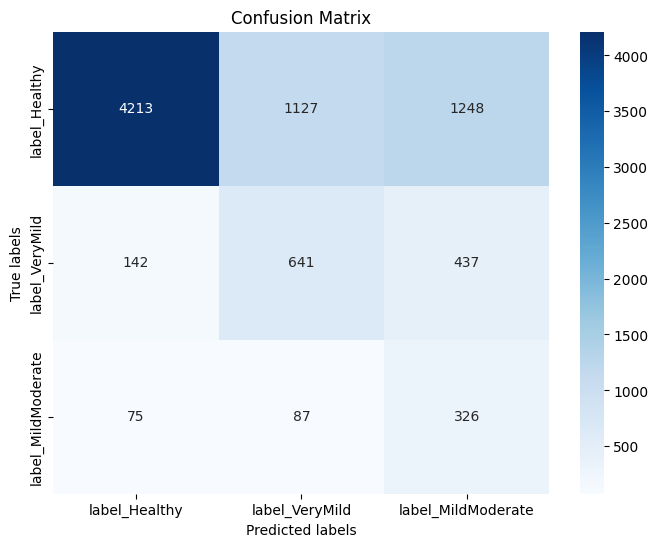

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


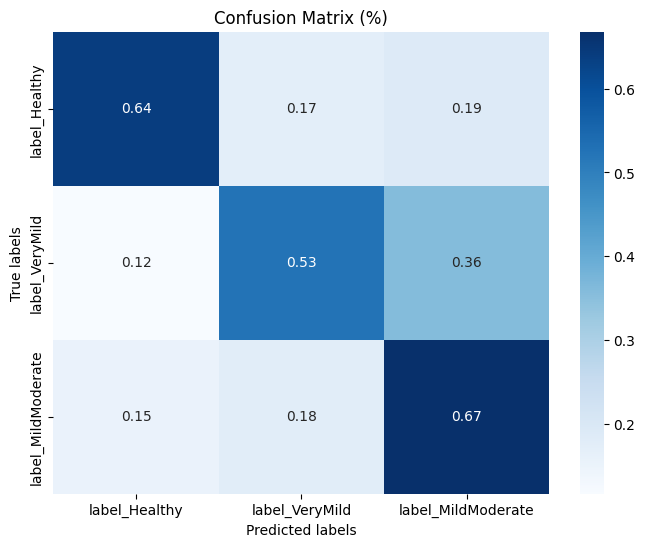

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, test_loader, class_names, percentage=False):
    # Ensure the model is in evaluation mode and on the correct device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            logits_norm = F.softmax(logits, dim=1)
            predicted = torch.argmax(logits_norm, dim=1)  # Predicted class labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if percentage:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
        fmt = ".2f"
        title = 'Confusion Matrix (%)'
    else:
        fmt = "d"
        title = 'Confusion Matrix'

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

class_names = ['label_Healthy', 'label_VeryMild', 'label_MildModerate']
plot_confusion_matrix(model, test_loader, class_names, percentage=False)  # For absolute counts
plot_confusion_matrix(model, test_loader, class_names, percentage=True)   # For percentages
